##Predicting House Prices in Mexico City##

##Introduction##

Housing is a fundamental aspect of urban life, shaping the economic, social, and environmental fabric of any city. Mexico City, one of the largest and most densely populated metropolitan areas in the world, presents a unique case for studying housing dynamics.

The primary aim of this project is to develop a predictive model that accurately estimates housing prices in Mexico City. By leveraging data on factors such as property size, location, and key features, the project seeks to uncover the underlying relationships that drive housing prices. This model will not only provide valuable insights into the current housing market but also serve as a tool for potential buyers, sellers, and policymakers to make informed decisions.

We will first import the neccesary libraries for our project. It will be updated throughout the processes.

In [ ]:
#!pip install category_encoders

In [4]:
# Import libraries here
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from category_encoders import OneHotEncoder

from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

##Preparing our Data##
We will now access our data in my google drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

# Path to your file in Google Drive
file_path = '/content/drive/MyDrive/mexico-real-estate-clean.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Display the DataFrame
print(df.head())


Mounted at /content/drive/
  property_type             state        lat         lon  area_m2  price_usd
0         house  Estado de México  19.560181  -99.233528      150   67965.56
1         house        Nuevo León  25.688436 -100.198807      186   63223.78
2     apartment          Guerrero  16.767704  -99.764383       82   84298.37
3     apartment          Guerrero  16.829782  -99.911012      150   94308.80
4         house           Yucatán  21.052583  -89.538639      205  105191.37


Checking our data description for missing values and other inconsistencies is a crucial step in preparing data for model building.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_type  1865 non-null   object 
 1   state          1865 non-null   object 
 2   lat            1736 non-null   float64
 3   lon            1736 non-null   float64
 4   area_m2        1865 non-null   int64  
 5   price_usd      1165 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 87.5+ KB


In [7]:
df.describe()

,lat,lon,area_m2,price_usd
count,1736.000000,1736.000000,1865.000000,1165.000000
mean,20.765410,-98.798575,171.000536,115399.014850
std,2.743425,4.882553,80.044505,65881.514963
min,15.752900,-117.054763,60.000000,33192.480000
25%,19.275200,-100.392553,103.000000,63223.780000
50%,19.620518,-99.204001,159.000000,99577.450000
75%,21.073428,-98.245911,220.000000,151210.200000
max,32.665619,-86.767539,385.000000,326733.660000


The dataset used in this project contains 1,865 entries and 6 features,2 of which are categorcal while the rest are numerical.We notice that the dataset includes some missing values, in the lat and lon columns (129 entries missing) and the price_usd column, where 700 entries lack price data. These missing values offer potential challenges in modelling which can be solved by filtering or imputation.

#Visualization#

We will create a histogram showing the distribution of apartment prices ("price_aprox_usd") in df using matplotlib.

Text(0.5, 1.0, 'Distribution of Apartment Prices')

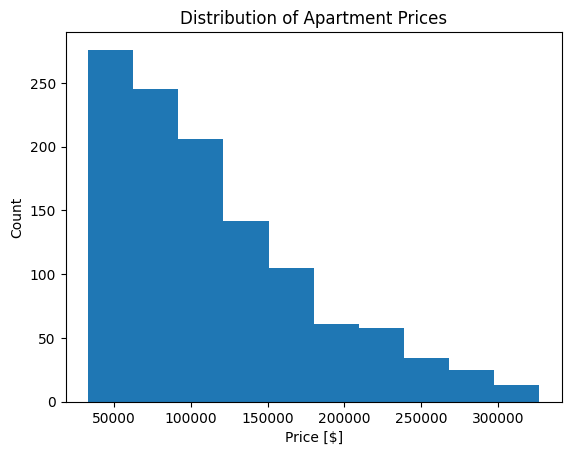

In [8]:
# Build histogram
plt.hist(df["price_usd"])

# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices")

A scatterplot will show apartment price ("price_aprox_usd") as a function of apartment size ("surface_covered_in_m2").

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

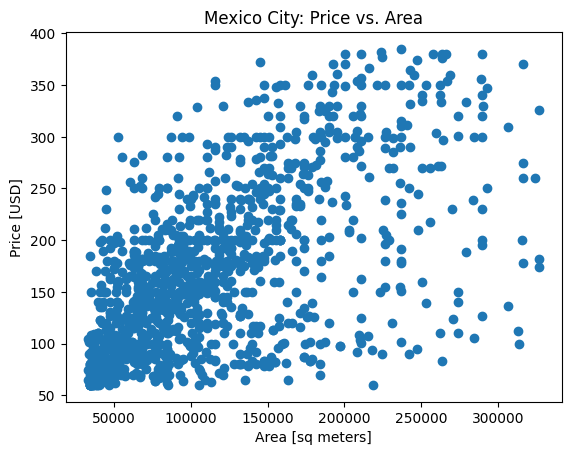

In [9]:
# Build scatter plot
plt.scatter(df["price_usd"],df["area_m2"])

# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area")

In [10]:
df["price_usd"].mode()

,price_usd
0,68492.42


We will create a correlation heatmap to relationships between our causative variables.

A correlation heatmap checks out for corelation between numerical columns and therefore do away with those that might lead to multicolinearity.

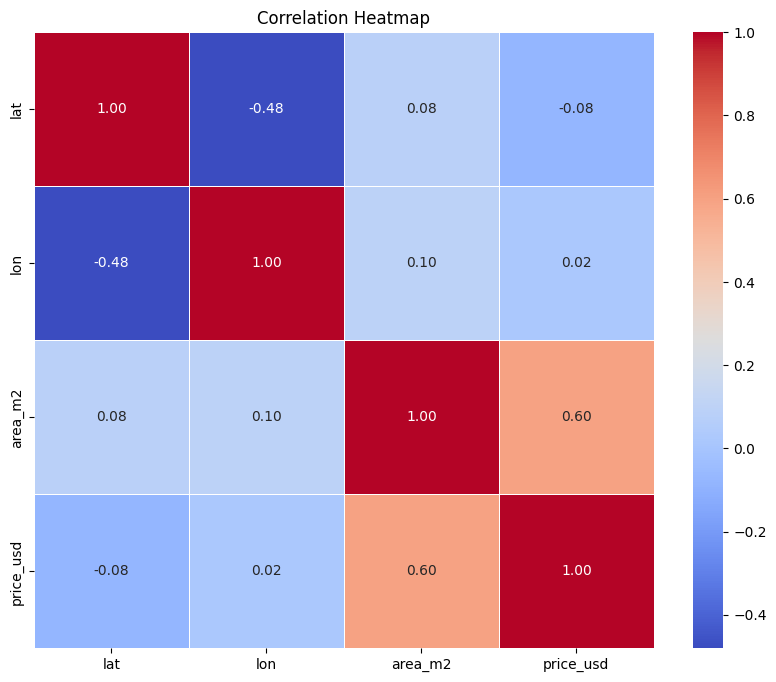

,lat,lon,area_m2,price_usd
lat,1.000000,-0.480231,0.082314,-0.077044
lon,-0.480231,1.000000,0.095522,0.020930
area_m2,0.082314,0.095522,1.000000,0.597199
price_usd,-0.077044,0.020930,0.597199,1.000000


In [11]:
Corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))  # Optional: set figure size
sns.heatmap(Corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.title("Correlation Heatmap")
plt.show()
Corr

##Data Splitting##

Data splitting involves dividing a dataset into distinct subsets, known as the training set, and test set. The training set is used to train the model by enabling it to learn patterns and relationships within the data. The test set provides an unbiased assessment of the model's predictive capability on unseen data. Note that the target variable  is "price_usd"

In [12]:
from sklearn.model_selection import train_test_split

# Split data into feature matrix `X_train` and target vector `y_train`.

X = df.drop(columns='price_usd')
y = df['price_usd']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42 )

#Model baseline#
A baseline model provides a simple point of reference to evaluate the performance of models.

The baseline model calculates the mean of the target variable (y_train.mean()) and uses this constant value as the prediction for every observation in the dataset. The mean_absolute_error metric is then used to measure the performance of this baseline, providing a simple yet meaningful starting point for model evaluation.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

# Impute missing values in y_train using SimpleImputer
imputer = SimpleImputer(strategy='mean') # or 'median', etc.
y_train = imputer.fit_transform(y_train.values.reshape(-1, 1))
y_train = y_train.ravel()

baseline_mae = mean_absolute_error(y_train,y_pred_baseline)

print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 116262.10703904556
Baseline MAE: 32616.648406803022


To streamline the machine learning workflow, create a pipeline named `model` that includes all the necessary transformers required for preprocessing the dataset. This pipeline ensures that data preprocessing and model training are executed seamlessly in a single step.

The model pipeline is constructed using the make_pipeline function and includes the following components:

1. OneHotEncoder(use_cat_names=True): This step encodes categorical variables into numerical format by creating binary columns for each category while retaining the original category names.
2. SimpleImputer(strategy='mean'): This step handles missing values in the dataset by replacing them with the mean of the respective column.
3. Ridge(): This is the Ridge regression model, which is used as the predictor. It applies regularization to prevent overfitting and improve the model's generalization.
This pipeline combines these preprocessing steps and the predictive model into a single, streamlined process.



Once the pipeline is defined, fit it to the training data to prepare the model for predictions on unseen data. This approach simplifies the process, reduces the risk of data leakage, and ensures consistency between training and testing phases.

In [14]:
model = model = make_pipeline(
    OneHotEncoder(use_cat_names =True),
    SimpleImputer(strategy='mean'),
    Ridge()
)

# Fit model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['property_type', 'state'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

#Evaluate#

We use the trained model pipeline to make predictions on the test dataset ,X_test.

In [19]:
y_train_pred = model.predict(X_train)

print(y_train_pred[:6])

[121644.66321641 124888.80709278  91380.80959328 120000.50577251
 155712.10195952 138015.12281453]


Calculate the training mean absolute error for your predictions as compared to the true targets in y_train.



In [16]:
# Calculate Mean Absolute Error
train_mae = mean_absolute_error(y_train, y_train_pred)

# Print the result
print("Training Mean Absolute Error (MAE):", train_mae)


Training Mean Absolute Error (MAE): 31741.9587022489


#Interpretation
The training MAE (31741.96) is lower than the baseline MAE (32616.65), which indicates that your model is performing better than simply predicting the mean price for all observations. This suggests that the model is effectively learning patterns in the data, improving upon the naive baseline approach.

##Communicating Results

We create a Series named feat_imp. The index should contain the names of all the features our model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.

In [26]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names_out()
feat_imp = pd.Series(coefficients, index = features)

# Sort the feature importance Series by absolute value in ascending order
feat_imp_sorted = feat_imp.sort_values(key=abs, ascending=False)
feat_imp_sorted.tail(5)

,0
state_Tabasco,1630.390975
lat,-1177.491257
state_Campeche,651.635083
area_m2,399.690736
lon,193.694618


The code above extracts and analyzes the importance of features in the Ridge regression model from the pipeline. It retrieves the model's coefficients and aligns them with their corresponding feature names, including encoded categorical variables. It highlights how each feature influences the target variable, helping identify the most impactful predictors. This step provides valuable insights into the relationships between features and housing prices.

To determine which features affect the target variable the most, you analyze the magnitude of the coefficients in the model.
The features with the largest absolute coefficients are the most impactful.Positive coefficients indicate a direct relationship, while negative coefficients indicate an inverse relationship.

Example:
A coefficient of +399.6907 for a feature like "area_m2" means an additional square foot increases the predicted price by 399.6907 dollars.


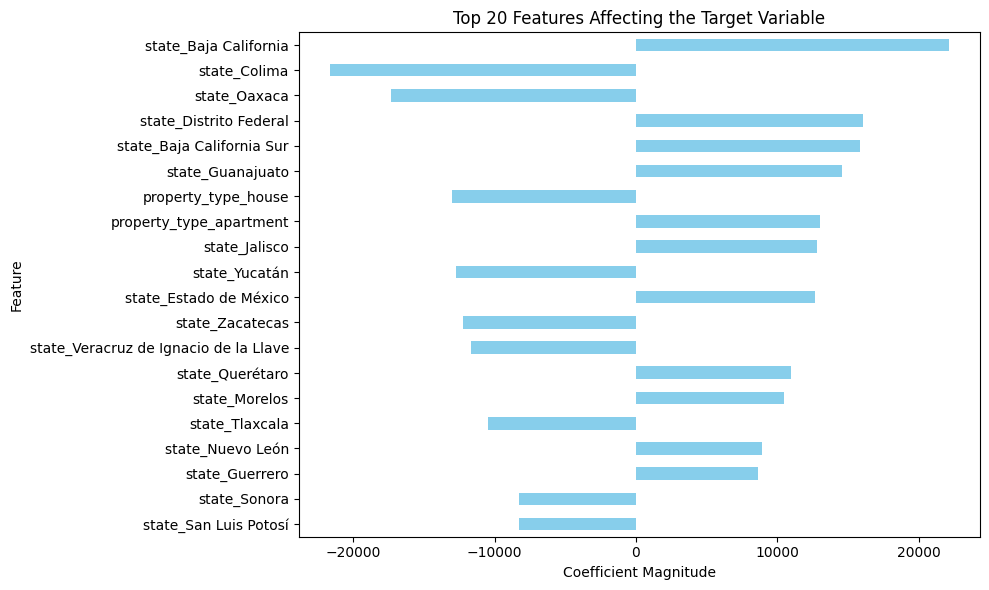

In [24]:
# Plot a bar chart for visualization
plt.figure(figsize=(10, 6))
feat_imp_sorted.head(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Features Affecting the Target Variable')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.tight_layout()
plt.show()

##Conclusion.

In conclusion, this project demonstrates how  feature engineering, and Ridge regression may be used to accurately predict house prices. By incorporating the model into a pipeline, we streamlined the data preparation and prediction processes.

The examination of feature importances revealed further insights into the elements that influence apartment pricing, allowing for a more relevant interpretation of the model's conclusions. This method not only improves prediction accuracy but also promotes openness, making it a valuable tool for data-driven decision-making and a better knowledge of the housing market.

Future developments could include adding more data sources, experimenting with different methods, and fine-tuning hyperparameters for even better performance.  